In [2]:
import torch
import torch.nn as nn
from horizon import signal, adjustment
import matplotlib.pyplot as plt
plt.style.use('default')
# auto reload packages
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Signal adjustment neural network
In this problem, two signals (or skylines) are considered:  
- The reference signal, representing the complete 360° skyline from a viewpoint
- The sub signal, which is a portion of the skyline at the same viewpoint, with eventual noise

The goal is to identify the azimuth (angle in degree), at which the sub signal can be superimposed to the reference.  

The reference signal is extracted from a digital terrain model (DTM), and does not consider trees, weather, nor any obstacle that could alter the real observed terrain.  
The sub signal is extracted from an image, and can differ from the reference signal due to all previously mentionned conditions. In addition, the camera can add some warping or slanting, and the algorithm that extracts the skyline from the image can also add noise to the final sub signal.  
In this training process, as it is difficult to obtain a dataset of skylines extracted from images, the sub signals are taken from the reference signals before normalization. Then, some noise is added and both are independantly normalized.  

These differences between both signals makes it difficult to align them properly. This is why it is proposed to train a neural network to identify how can the sub signal be corrected to better align it to its reference.  

The inputs are statistics on both signals, such as mean, standard deviation, maximum and minimun. The outputs are two parameters (a weight w and a bias b), that will be used to correct the normalized sub signal:  
`sub_signal_adjusted = sub_signal * w + b`  

To measure the quality of these predictions, the adjusted sub signals are compared to the references using cross correlation, or square diff. These techniques aims to find the best match between a reference signal and all possible positions of a second signal. In this case, the best match is the predicted azimuth, and it can be compared with ground truth azimuths generated during the data creation process.  

## Data gathering and preparation
Skylines from a diverse set of viewpoints has been previously extracted (see [`viewpoints_extraction.ipynb`](viewpoints_extraction.ipynb)), with tools like osmnx to get data from Open Street Map, elevation to get DTM, and projection operations to transform coordinates and keep only skyline points.

In [4]:
horizon_data = "../../data/horizon/OSM/"
fov = 87 # sub signal length
loader = adjustment.SignalLoader()
loader.load_from_dir(horizon_data, fov)
loader.prepare_train_test_val()

- S0 will contain normalized reference signals
- S1 will contain normalized sub signals
- X will contain the statistical features of each pair of signals to give as input to the nn
- Y will contain the indexes of each signal, as well as the ground truth azimuths used to extract sub signals from references

## Define the model and its hyperparameters

In [37]:
model = adjustment.AdjustmentModel(inputsize=loader.x_train.shape[1])

In [158]:
# load from trained model
modelpath='../../data/models/trained_signal_adjustment.pth'
model = adjustment.AdjustmentModel(inputsize=loader.x_train.shape[1], load_from=modelpath)


Faster pre-train with `loss_fct = signal_correction_loss` and `learning_rate=2e-5`  
Then, train with `loss_fct = signals_correlation_loss` and `learning_rate=1e-6`    

In [111]:
learning_rate=2e-5
optimizer=torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
loss_fct = loader.signal_correction_loss

## Train

In [130]:
model.train_with_hp(loader, optimizer, loss_fct, epochs=8000)

Epoch 0, train loss 0.03688893839716911, val loss 0.01624351553618908
Epoch 1, train loss 0.038490284234285355, val loss 0.016253752633929253
Epoch 2, train loss 0.04178420826792717, val loss 0.016307037323713303
Epoch 3, train loss 0.035038530826568604, val loss 0.01634219102561474
Epoch 4, train loss 0.03019801527261734, val loss 0.016352789476513863
Epoch 5, train loss 0.03312866762280464, val loss 0.016368389129638672
Epoch 6, train loss 0.033834610134363174, val loss 0.016348673030734062
Epoch 7, train loss 0.03898829594254494, val loss 0.01632878929376602
Epoch 8, train loss 0.0373167023062706, val loss 0.016304239630699158
Epoch 9, train loss 0.043428197503089905, val loss 0.016314532607793808
Epoch 10, train loss 0.04187512770295143, val loss 0.01628860831260681
Epoch 11, train loss 0.04565172269940376, val loss 0.016293197870254517
Epoch 12, train loss 0.03167557343840599, val loss 0.016285492107272148
Epoch 13, train loss 0.03890844061970711, val loss 0.01631520316004753
Epoc

In [153]:
# optionnal, train with another loss
model.dropout = nn.Dropout(p=0.01) # reduce dropout
learning_rate=1e-5
optimizer=torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
loss_fct = loader.signals_correlation_loss

model.train_with_hp(loader, optimizer, loss_fct, epochs=500)

Epoch 0, train loss 0.7003386616706848, val loss 0.7322039008140564
Epoch 1, train loss 0.7209444642066956, val loss 0.7354879975318909
Epoch 2, train loss 0.7207324504852295, val loss 0.7331122756004333
Epoch 3, train loss 0.7146633267402649, val loss 0.7379319667816162
Epoch 4, train loss 0.6997165083885193, val loss 0.7305458188056946
Epoch 5, train loss 0.7153180837631226, val loss 0.7368535399436951
Epoch 6, train loss 0.7248571515083313, val loss 0.7693929076194763
Epoch 7, train loss 0.6851409077644348, val loss 0.7456662654876709
Epoch 8, train loss 0.6994220614433289, val loss 0.727777898311615
Epoch 9, train loss 0.6853386759757996, val loss 0.7292792201042175
Epoch 10, train loss 0.697617769241333, val loss 0.729077160358429
Epoch 11, train loss 0.6946991086006165, val loss 0.7287242412567139
Epoch 12, train loss 0.6999086737632751, val loss 0.7391807436943054
Epoch 13, train loss 0.6912920475006104, val loss 0.7341984510421753
Epoch 14, train loss 0.7021322846412659, val lo

## Evaluate

In [ ]:
model.plot_losses(start=1000)

Test correction loss 0.02563449740409851
Test correlation loss 1.0395712852478027
Mean error without adjustement: 65.16017150878906, Median error: 8.0
Mean error with adjustement: 1.3246753215789795, Median error: 0.0


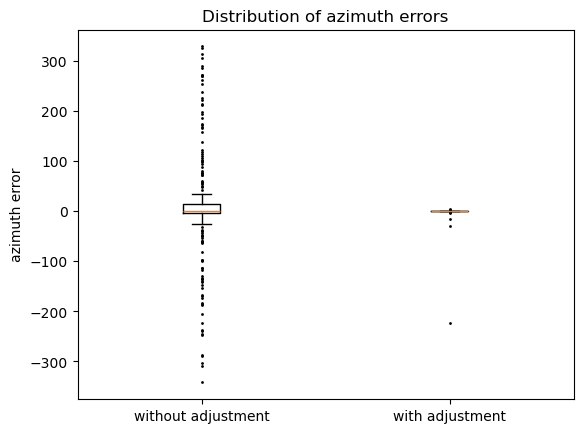

In [159]:
model.eval_compare(loader)

In [129]:
# save if results are satisfying
model.save_parameters(modelpath)

Example of signals matching improvements 

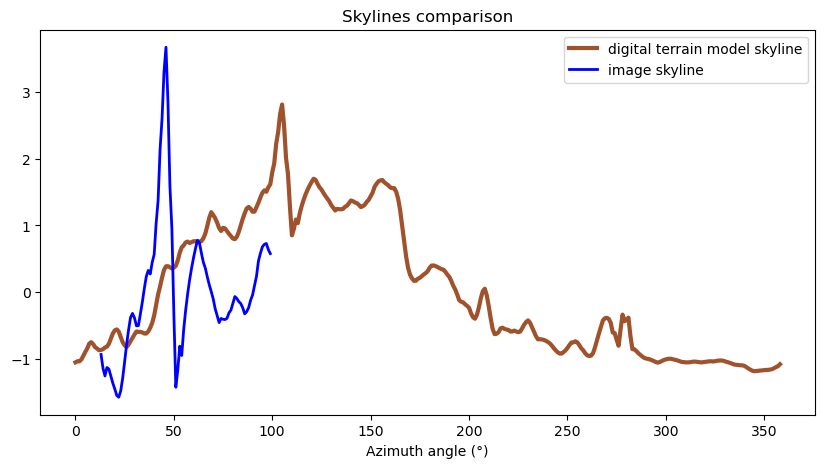

<Figure size 640x480 with 0 Axes>

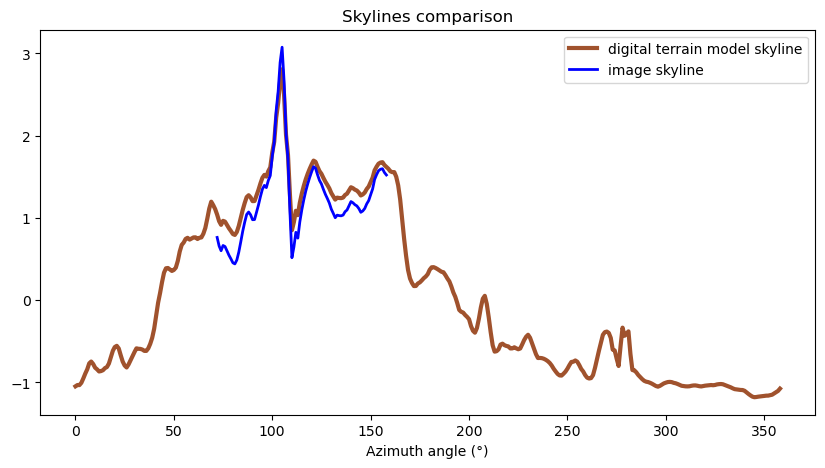

<Figure size 640x480 with 0 Axes>

In [163]:
k=2
ref_s = loader.S0[loader.y_test[k,0]]
sub_s = loader.S1[loader.y_test[k,0]]
fig = signal.plot_skylines_comparison(ref_s, sub_s)
pred = model(loader.x_test[k])
sub_s_corrected = sub_s*pred[0]+pred[1]
fig = signal.plot_skylines_comparison(ref_s, sub_s_corrected)